In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


94 5 40
📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    3256.000000  3256.000000
mean    40150.619340     2.022834
std     56176.374822     0.785525
min       452.360000     0.375449
25%      6606.907500     1.450135
50%     17814.810000     2.002405
75%     53415.565000     2.591298
max    539900.600000     4.036102


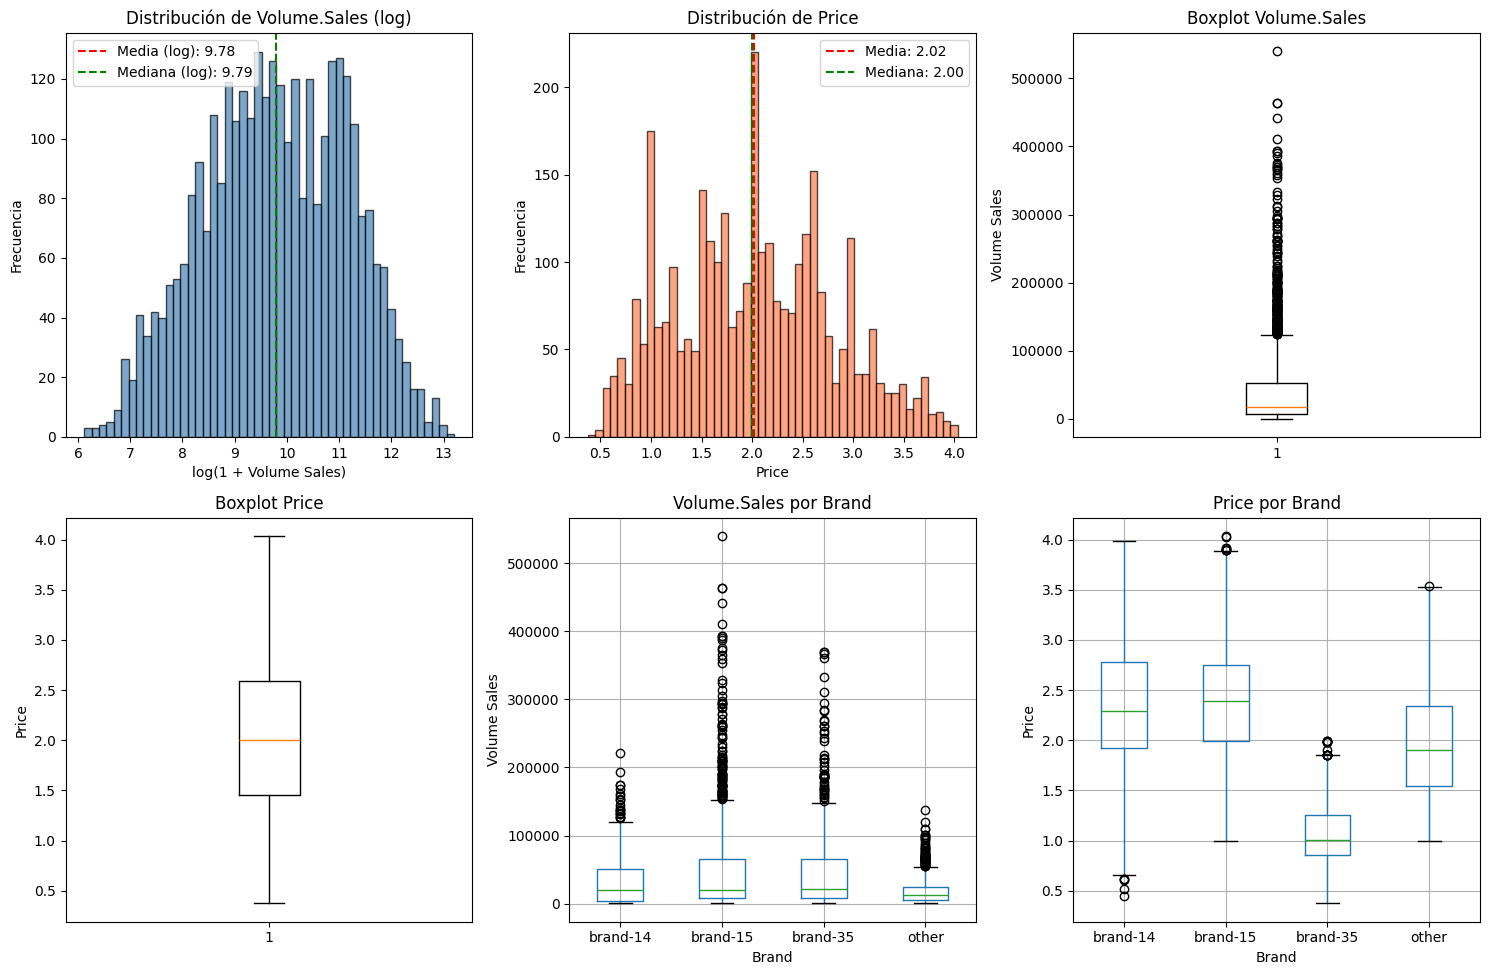


📊 DISTRIBUCIÓN POR CATEGORÍAS


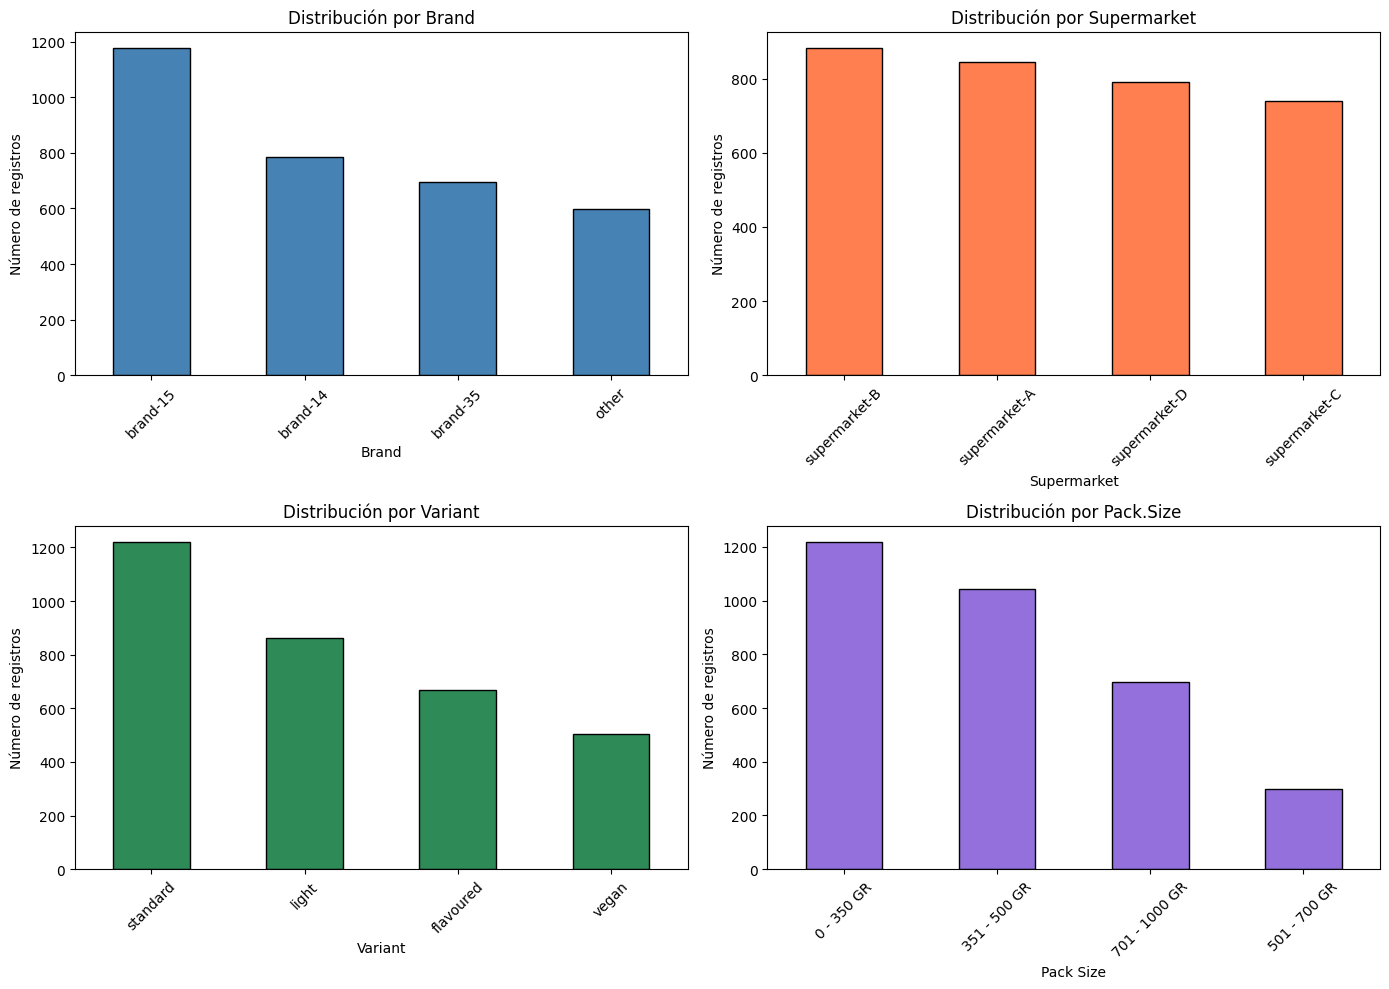


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0398


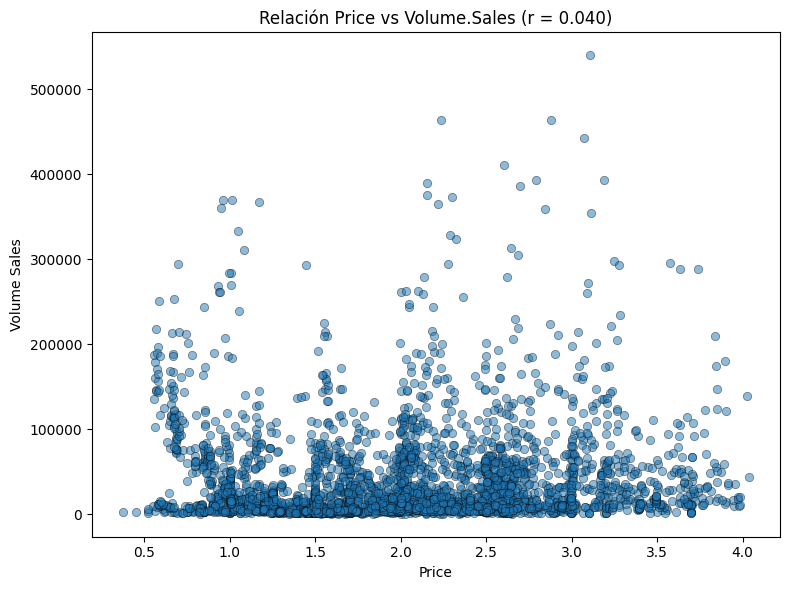

In [2]:
%run 1_preprocessing_data.ipynb
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


BUILD DATASET

In [3]:
# ============================================================================
# PASO 2: Construcción del dataset de forecasting
# ============================================================================

# Variables temporales
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Lags del target (por series_id) - CRÍTICO: agrupar por series_id
data['lag_1'] = data.groupby('series_id')['volume.sales'].shift(1)
data['lag_2'] = data.groupby('series_id')['volume.sales'].shift(2)
data['lag_3'] = data.groupby('series_id')['volume.sales'].shift(3)
data['lag_12'] = data.groupby('series_id')['volume.sales'].shift(12)

# Rolling means - CRÍTICO: usar shift(1) antes de rolling para evitar leakage
# Primero hacer shift(1) por grupo, luego aplicar rolling dentro de cada grupo
data['volume_sales_shifted'] = data.groupby('series_id')['volume.sales'].shift(1)
data['rolling_mean_3'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_mean_6'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=6, min_periods=1).mean().reset_index(0, drop=True)
data = data.drop(columns=['volume_sales_shifted'])  # Eliminar columna temporal

# Variables de precio
data['price_lag_1'] = data.groupby('series_id')['price'].shift(1)
data['price_lag_12'] = data.groupby('series_id')['price'].shift(12)

# Renombrar pack.size para consistencia
data['pack_size'] = data['pack.size']

TRANSFORM TARGET AND PREPARATION

In [4]:
# ============================================================================
# PASO 3: Transformación del target y preparación para modelado
# ============================================================================

# Transformar target con log1p
data['target_log'] = np.log1p(data['volume.sales'])

# Seleccionar columnas para el modelo
feature_cols = [
    'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_12',
    'rolling_mean_3', 'rolling_mean_6',
    'price', 'price_lag_1', 'price_lag_12',
    'brand', 'supermarket', 'variant', 'pack_size'
]

categorical_features = ['brand', 'supermarket', 'variant', 'pack_size']

TRAIN_DATA AND TEST_DATA

In [5]:
data_work = data.copy()

data_work = data_work.sort_values('date').reset_index(drop=True)

# Calcular fecha de corte (80% del rango temporal)
date_min = data_work['date'].min()
date_max = data_work['date'].max()
date_range = date_max - date_min
train_cutoff = date_min + date_range * 0.8

train_data = data_work[data_work['date'] <= train_cutoff].copy()
test_data = data_work[data_work['date'] > train_cutoff].copy()

In [6]:
# ============================================================================
# PASO 5: Manejo de NaNs por lags
# CRÍTICO: Eliminar filas donde lag_12 es NaN antes de entrenar
# ============================================================================

# Eliminar filas con lag_12 NaN (opción simple recomendada)
train_data_clean = train_data.dropna(subset=['lag_12']).copy()
test_data_clean = test_data.dropna(subset=['lag_12']).copy()

print(f"Train después de eliminar NaNs de lag_12: {len(train_data_clean)} filas (se perdieron {len(train_data) - len(train_data_clean)} filas)")
print(f"Test después de eliminar NaNs de lag_12: {len(test_data_clean)} filas (se perdieron {len(test_data) - len(test_data_clean)} filas)")

# Verificar que no haya más NaNs en las features
print(f"\nNaNs en train_data_clean:")
print(train_data_clean[feature_cols].isnull().sum())

# Si hay NaNs en otras features, eliminarlos también
train_data_clean = train_data_clean.dropna(subset=feature_cols + ['target_log'])
test_data_clean = test_data_clean.dropna(subset=feature_cols + ['target_log'])

print(f"\nTrain final: {len(train_data_clean)} filas")
print(f"Test final: {len(test_data_clean)} filas")

Train después de eliminar NaNs de lag_12: 1528 filas (se perdieron 1128 filas)
Test después de eliminar NaNs de lag_12: 600 filas (se perdieron 0 filas)

NaNs en train_data_clean:
month             0
year              0
lag_1             0
lag_2             0
lag_3             0
lag_12            0
rolling_mean_3    0
rolling_mean_6    0
price             0
price_lag_1       0
price_lag_12      0
brand             0
supermarket       0
variant           0
pack_size         0
dtype: int64

Train final: 1528 filas
Test final: 600 filas


In [7]:
# ============================================================================
# PASO 6: Preparar datos para CatBoost
# ============================================================================

# Separar features y target
X_train = train_data_clean[feature_cols].copy()
y_train = train_data_clean['target_log'].copy()

X_test = test_data_clean[feature_cols].copy()
y_test = test_data_clean['target_log'].copy()

# Guardar valores originales para métricas
y_test_original = test_data_clean['volume.sales'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1528, 15)
X_test shape: (600, 15)


CATBOOST

In [ ]:
# ============================================================================
# PASO 7: Entrenamiento del modelo CatBoost
# ============================================================================

# Obtener índices de features categóricas
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

model = CatBoostRegressor(
    loss_function='MAE',
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
    cat_features=cat_indices
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=100
)

0:	learn: 1.0389567	test: 1.0014792	best: 1.0014792 (0)	total: 75.7ms	remaining: 37.8s
100:	learn: 0.2174349	test: 0.2678146	best: 0.2678146 (100)	total: 233ms	remaining: 921ms
200:	learn: 0.1690453	test: 0.2658571	best: 0.2644082 (156)	total: 367ms	remaining: 546ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2644082092
bestIteration = 156

Shrink model to first 157 iterations.


In [20]:
# PASO 8: Evaluación del modelo

# Predicciones en escala log
y_pred_log = model.predict(X_test)

# Transformar de vuelta a escala original
y_pred = np.expm1(y_pred_log)
y_test_vals = y_test_original.values

# Funciones para calcular métricas
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / (denominator + 1e-9)) * 100

def wape(y_true, y_pred):
    """Weighted Absolute Percentage Error"""
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    return (numerator / (denominator + 1e-9)) * 100

# Calcular métricas
mae = mean_absolute_error(y_test_vals, y_pred)
smape_val = smape(y_test_vals, y_pred)
wape_val = wape(y_test_vals, y_pred)

print("=" * 60)
print("MÉTRICAS EN TEST SET (agregadas)")
print("=" * 60)
print(f"MAE:  {mae:.4f}")
print(f"sMAPE: {smape_val:.4f}%")
print(f"WAPE: {wape_val:.4f}%")
print("=" * 60)


MÉTRICAS EN TEST SET (agregadas)
MAE:  9435.7831
sMAPE: 25.6997%
WAPE: 23.5682%


SHAP - Interpretabilidad del Modelo

In [21]:
# Instalar si es necesario: !pip install shap
import shap
shap.initjs()  # Para visualizaciones interactivas en Jupyter

In [22]:
# TreeExplainer está optimizado para modelos basados en árboles (CatBoost, XGBoost, etc.)
explainer = shap.TreeExplainer(model)

# Calcular SHAP values para el conjunto de test
# Nota: puede tardar unos segundos dependiendo del tamaño de X_test
shap_values = explainer.shap_values(X_test)

print(f"Shape de shap_values: {shap_values.shape}")
print(f"Expected value (baseline): {explainer.expected_value:.4f}")

Shape de shap_values: (600, 15)
Expected value (baseline): 9.7987


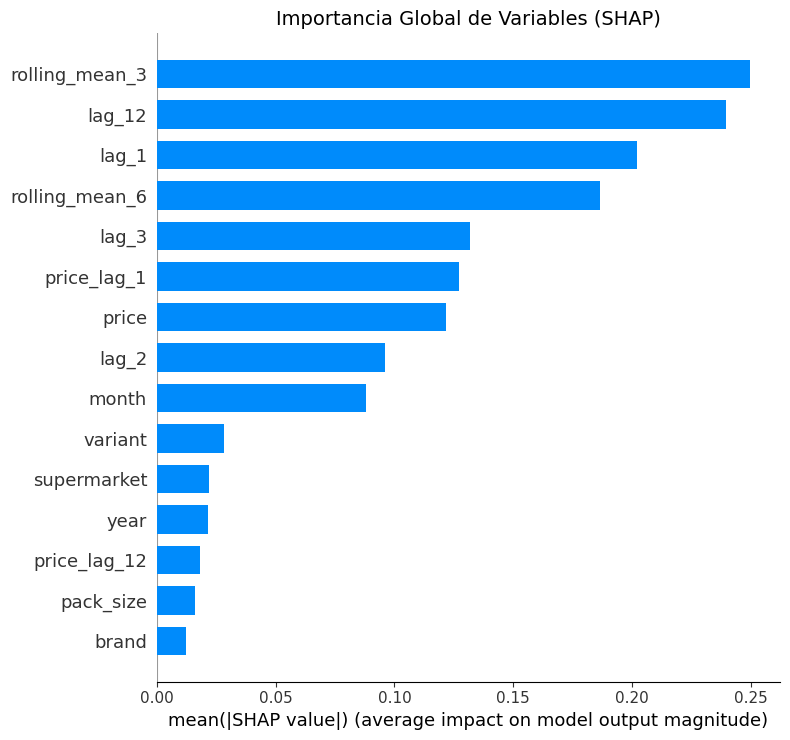

In [23]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importancia Global de Variables (SHAP)", fontsize=14)
plt.tight_layout()
plt.savefig("../images_markdown/shap_importance_bar.png", dpi=150, bbox_inches='tight')
plt.show()

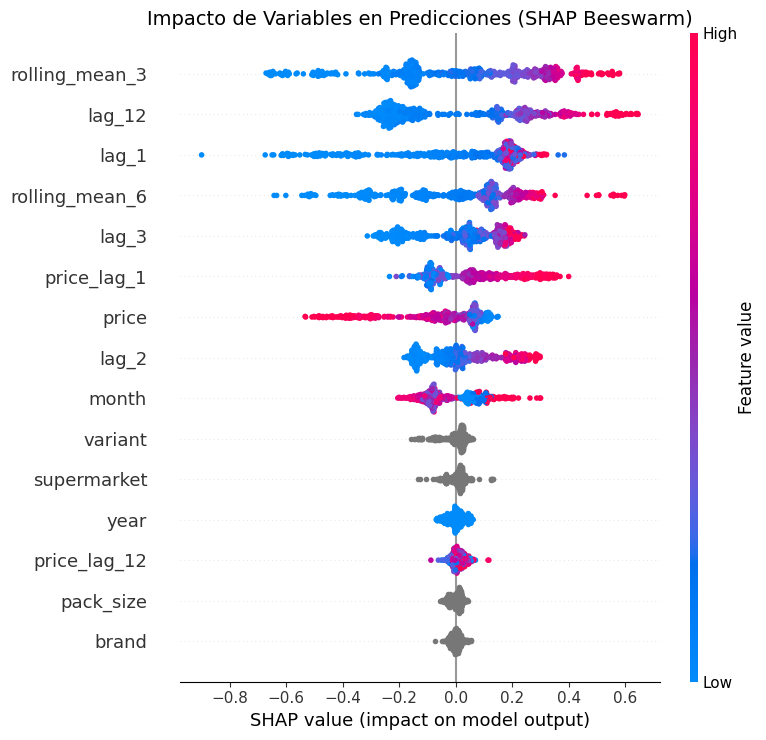

In [24]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Impacto de Variables en Predicciones (SHAP Beeswarm)", fontsize=14)
plt.tight_layout()
plt.savefig("../images_markdown/shap_beeswarm.png", dpi=150, bbox_inches='tight')
plt.show()

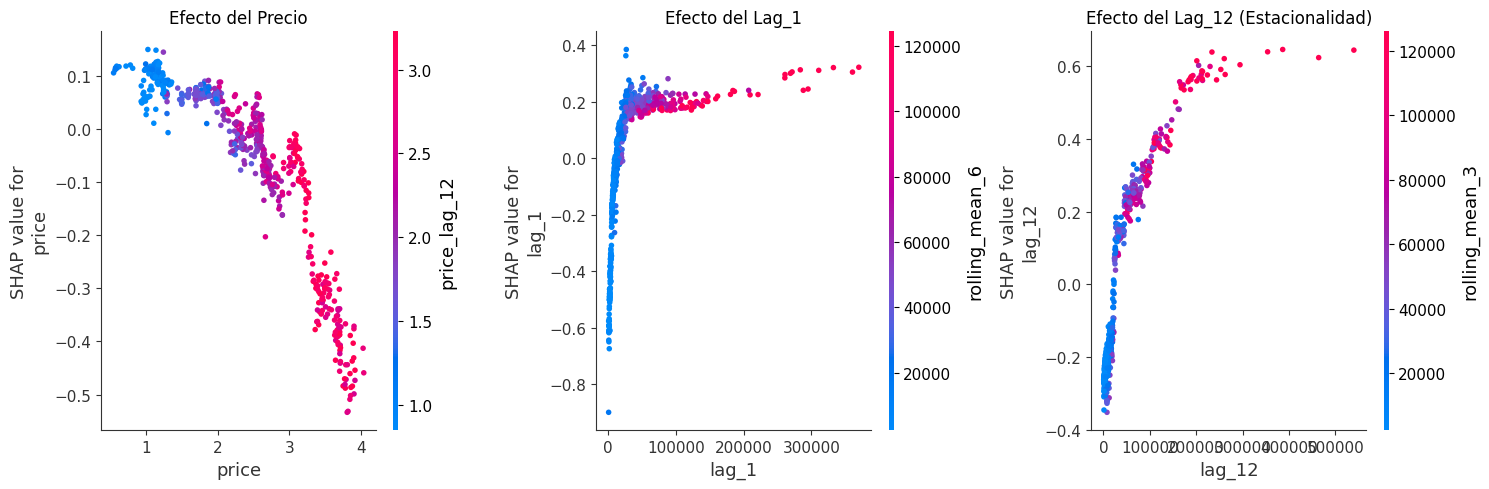

In [25]:
# Dependence plot para PRECIO (variable exógena principal)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Usar ax= para que cada plot se dibuje en su subplot (evita que SHAP cree figuras nuevas)
shap.dependence_plot("price", shap_values, X_test, ax=axes[0], show=False)
axes[0].set_title("Efecto del Precio")

shap.dependence_plot("lag_1", shap_values, X_test, ax=axes[1], show=False)
axes[1].set_title("Efecto del Lag_1")

shap.dependence_plot("lag_12", shap_values, X_test, ax=axes[2], show=False)
axes[2].set_title("Efecto del Lag_12 (Estacionalidad)")

plt.tight_layout()
plt.savefig("../images_markdown/shap_dependence.png", dpi=150, bbox_inches='tight')
plt.show()

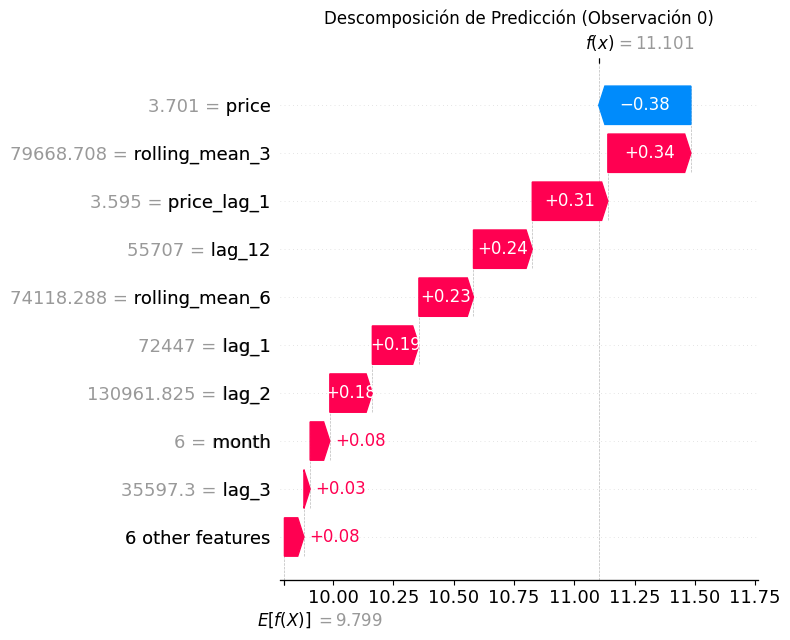

In [26]:
# Seleccionar una observación de ejemplo (ej: la primera del test)
idx = 0

# Crear Explanation object para waterfall
explanation = shap.Explanation(
    values=shap_values[idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[idx],
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.plots.waterfall(explanation, show=False)
plt.title(f"Descomposición de Predicción (Observación {idx})", fontsize=12)
plt.tight_layout()
plt.savefig("../images_markdown/shap_waterfall.png", dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# Crear DataFrame con ranking de importancia
importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'SHAP_Mean_Abs': np.abs(shap_values).mean(axis=0),
    'SHAP_Std': np.abs(shap_values).std(axis=0)
}).sort_values('SHAP_Mean_Abs', ascending=False)

# Añadir porcentaje de importancia
importance_df['Importancia_%'] = (
    importance_df['SHAP_Mean_Abs'] / importance_df['SHAP_Mean_Abs'].sum() * 100
)

print("=" * 60)
print("RANKING DE IMPORTANCIA DE VARIABLES (SHAP)")
print("=" * 60)
print(importance_df.to_string(index=False, float_format="%.4f"))
print("=" * 60)

# Guardar como CSV
importance_df.to_csv('shap_importance.csv', index=False)

RANKING DE IMPORTANCIA DE VARIABLES (SHAP)
      Variable  SHAP_Mean_Abs  SHAP_Std  Importancia_%
rolling_mean_3         0.2498    0.1620        16.0052
        lag_12         0.2396    0.1126        15.3547
         lag_1         0.2019    0.1418        12.9373
rolling_mean_6         0.1866    0.1253        11.9577
         lag_3         0.1317    0.0740         8.4365
   price_lag_1         0.1270    0.0917         8.1406
         price         0.1217    0.1248         7.7960
         lag_2         0.0961    0.0769         6.1546
         month         0.0881    0.0422         5.6465
       variant         0.0282    0.0262         1.8041
   supermarket         0.0219    0.0188         1.4021
          year         0.0215    0.0163         1.3776
  price_lag_12         0.0183    0.0157         1.1749
     pack_size         0.0161    0.0101         1.0312
         brand         0.0122    0.0103         0.7810


In [28]:
# Interaction values (puede ser computacionalmente costoso)
# Descomenta si quieres ver interacciones entre variables
# shap_interaction = explainer.shap_interaction_values(X_test[:100])
# shap.summary_plot(shap_interaction, X_test[:100])

In [32]:
# Mostrar top 5 variables más importantes
print("\n" + "=" * 60)
print("TOP 5 VARIABLES MÁS IMPORTANTES")
print("=" * 60)
for i, row in importance_df.head(5).iterrows():
    print(f"  {row['Variable']}: {row['Importancia_%']:.1f}%")
print("=" * 60)

# Interpretación automática
print("\nINTERPRETACIÓN:")
top_var = importance_df.iloc[0]['Variable']
if 'lag' in str(top_var):
    print(f"  - La variable más importante es {top_var}, indicando alta autocorrelación")
if 'price' in importance_df.head(3)['Variable'].values:
    print("  - El precio es una variable significativa para las predicciones")
if 'month' in importance_df.head(5)['Variable'].values:
    print("  - Existe componente estacional capturado por el mes")


TOP 5 VARIABLES MÁS IMPORTANTES
  rolling_mean_3: 16.0%
  lag_12: 15.4%
  lag_1: 12.9%
  rolling_mean_6: 12.0%
  lag_3: 8.4%

INTERPRETACIÓN:
